<a href="https://colab.research.google.com/github/A790227/Final-Project-Lighthouse/blob/main/raw_process_385%20reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nltk spacy gensim


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
pip install transformers torch


In [ ]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Encode some input text
input_ids = tokenizer.encode('As an example of NLP, ', return_tensors='pt')

# Load pre-trained model (weights)
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Generate text until the output length (which includes the given input) reaches 50 tokens
output = model.generate(input_ids, max_length=50, pad_token_id=tokenizer.eos_token_id)

# Decode the output token ids
decoded_output = tokenizer.decode(output[0])

print(decoded_output)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


As an example of NLP,  the first sentence of the sentence is a simple example of the NLP.  The second sentence is a simple example of the NLP.  The third sentence is a simple example of the N


In [ ]:
pip install nltk


In [ ]:
!pip install datasets


In [ ]:
from datasets import load_dataset

ds = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Beauty_and_Personal_Care")



DatasetDict({
    full: Dataset({
        features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
        num_rows: 23911390
    })
})
Total number of rows: 23911390
Calculated sample size: 385
Sampled dataset: Dataset({
    features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
    num_rows: 385
})


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Sample saved to sampled_data.jsonl


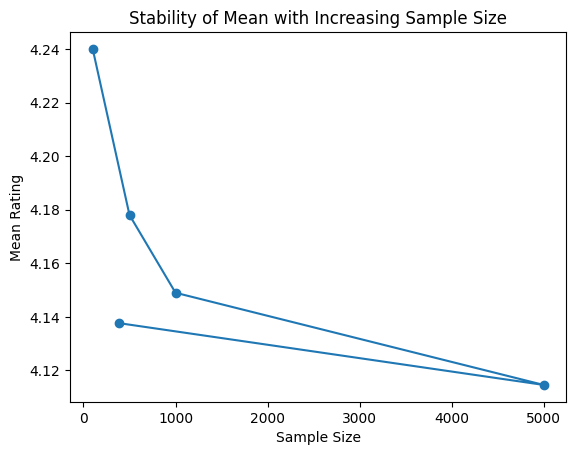

In [ ]:
from datasets import load_dataset
from math import ceil
import matplotlib.pyplot as plt

# Step 1: Load the Dataset
ds = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Beauty_and_Personal_Care")
print(ds)

# Access the 'full' split
split_name = 'full'
population_size = len(ds[split_name])
print(f"Total number of rows: {population_size}")

# Step 2: Calculate Sample Size
def calculate_sample_size(population_size, confidence_level=0.95, margin_of_error=0.05, proportion=0.5):
    z_scores = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}
    z = z_scores[confidence_level]
    numerator = (z**2) * proportion * (1 - proportion)
    denominator = margin_of_error**2
    sample_size = numerator / denominator
    sample_size = sample_size / (1 + (sample_size - 1) / population_size)  # Adjust for finite population
    return ceil(sample_size)

# Calculate the sample size
sample_size = calculate_sample_size(population_size)
print(f"Calculated sample size: {sample_size}")

# Step 3: Randomly Sample the Dataset
sampled_ds = ds[split_name].shuffle(seed=42).select(range(sample_size))
print(f"Sampled dataset: {sampled_ds}")

# Step 4: Save the Sample
sampled_ds.to_json("sampled_data.jsonl")
print("Sample saved to sampled_data.jsonl")

# Step 5: Evaluate Sample Stability
# Analyze a metric across different sample sizes
sample_sizes = [100, 500, 1000, 5000, sample_size]
means = []

for size in sample_sizes:
    sample = ds[split_name].shuffle(seed=42).select(range(size))
    mean_rating = sum(sample['rating']) / len(sample)  # Replace 'rating' with the actual column
    means.append(mean_rating)

# Plot the stability of the mean
plt.plot(sample_sizes, means, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Mean Rating')
plt.title('Stability of Mean with Increasing Sample Size')
plt.show()

# Data Preprocessing

In [ ]:
from datasets import load_dataset
import re
from nltk.corpus import stopwords
import string
import nltk

# Download required NLTK resources
nltk.download('stopwords')

# Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Prepare stop words and punctuation
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

def preprocess_text(text):
    """
    Preprocess a given text: lowercase, remove punctuation, tokenize, and remove stopwords.
    """
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation using regex
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)

    # Split into words (tokens)
    tokens = text.split()

    # Remove stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    return cleaned_tokens

# Example: Process the first review
sample_review = ds[0]['text']  # Adjust field name if necessary
print("Original Review:", sample_review)

processed_review = preprocess_text(sample_review)
print("\nProcessed Tokens:", processed_review)

# Optional: Process all reviews and store results
processed_reviews = [preprocess_text(review['text']) for review in ds]
print("\nExample Processed Reviews:", processed_reviews[:5])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Generating train split: 0 examples [00:00, ? examples/s]

Original Review: Not sure why, but these don’t hold my hair back they slip down. They don’t clip tight like the ones that don’t have the rubber dots

Processed Tokens: ['sure', 'don’t', 'hold', 'hair', 'back', 'slip', 'don’t', 'clip', 'tight', 'like', 'ones', 'don’t', 'rubber', 'dots']

Example Processed Reviews: [['sure', 'don’t', 'hold', 'hair', 'back', 'slip', 'don’t', 'clip', 'tight', 'like', 'ones', 'don’t', 'rubber', 'dots'], ['pictures', 'transfer', 'great', 'wonderful', 'product'], ['horrible', 'flakes', 'dandruff', 'like', 'crazy', 'african', 'american', 'itches', 'like', 'crazyand', 'head', 'shoulders', 'takes', 'care', 'issuewith', 'daily', 'wash', 'works', 'wonders', 'head', 'smells', 'great'], ['lovely', 'smell', 'expected', 'raspberry', 'cream', 'nice', 'lavender', 'relaxing'], ['certainly', 'going', 'long', 'term', 'customer', 'customer', 'service', 'excellent', 'love', 'product', 'love', 'feels', 'skin', 'love', 'dries', 'feel', 'icky', 'make', 'flakes', 'dry']]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


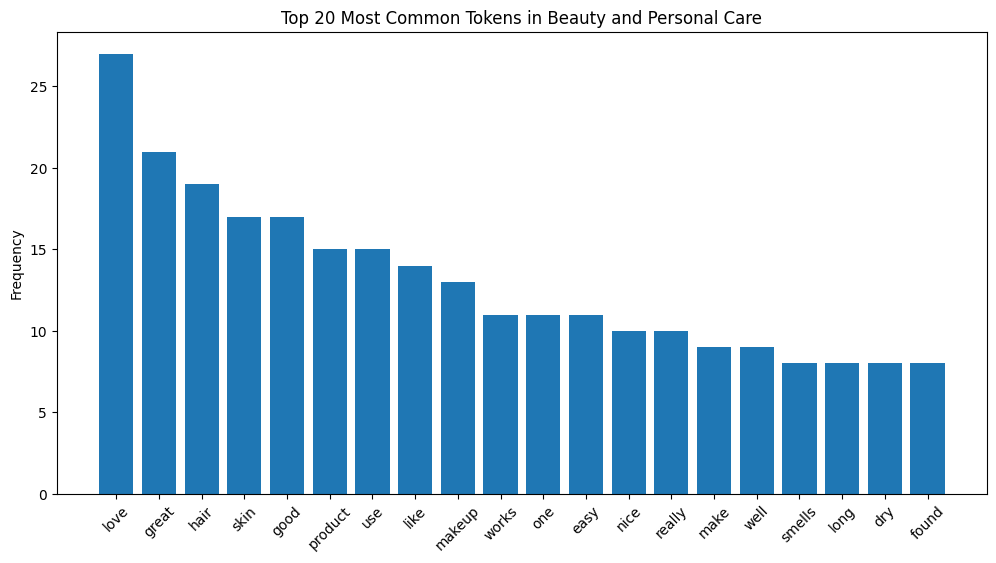

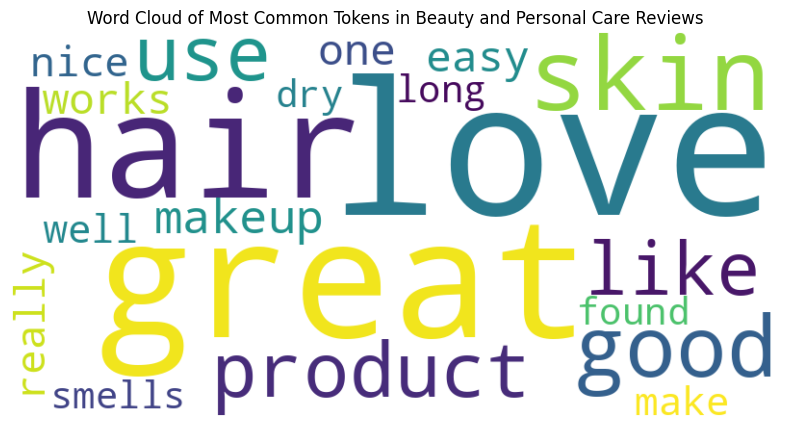

In [ ]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk.corpus import stopwords
import re
import string
from collections import Counter
from wordcloud import WordCloud
import nltk

# Download necessary resources
nltk.download('stopwords')

# Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Initialize tools
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

# Preprocess text: remove punctuation, stopwords, and tokenize
def preprocess_text(text):
    # Convert to lowercase and remove punctuation
    text = re.sub(f"[{re.escape(punctuation)}]", "", text.lower())
    # Tokenize by splitting
    tokens = text.split()
    # Remove stopwords
    cleaned_tokens = [token for token in tokens if token not in stop_words]
    return cleaned_tokens

# Preprocess the first 100 reviews
all_tokens = []
for i in range(100):
    tokens = preprocess_text(ds[i]['text'])
    all_tokens.extend(tokens)

# Get the 20 most common tokens
common_tokens = Counter(all_tokens).most_common(20)
tokens, frequencies = zip(*common_tokens)

# Plot 1: Bar plot of the most common tokens
plt.figure(figsize=(12, 6))
plt.bar(tokens, frequencies)
plt.title('Top 20 Most Common Tokens in Beauty and Personal Care')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

# Plot 2: Word cloud of the most common tokens
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Tokens in Beauty and Personal Care Reviews')
plt.show()

# Representation

In [ ]:
!pip install datasets scikit-learn nltk

BoW Representation (First 5 Rows):
   br  color  dry  easy  good  great  hair  like  long  love  make  makeup  \
0   0      0    0     0     0      0     1     1     0     0     0       0   
1   0      0    0     0     0      1     0     0     0     0     0       0   
2   0      0    0     0     0      1     0     2     0     0     0       0   
3   0      0    0     0     0      0     0     0     0     0     0       0   
4   0      0    1     0     0      0     0     0     1     3     1       0   

   nice  one  product  really  skin  use  well  works  
0     0    0        0       0     0    0     0      0  
1     0    0        1       0     0    0     0      0  
2     0    0        0       0     0    0     0      1  
3     1    0        0       0     0    0     0      0  
4     0    0        1       0     1    0     0      0  


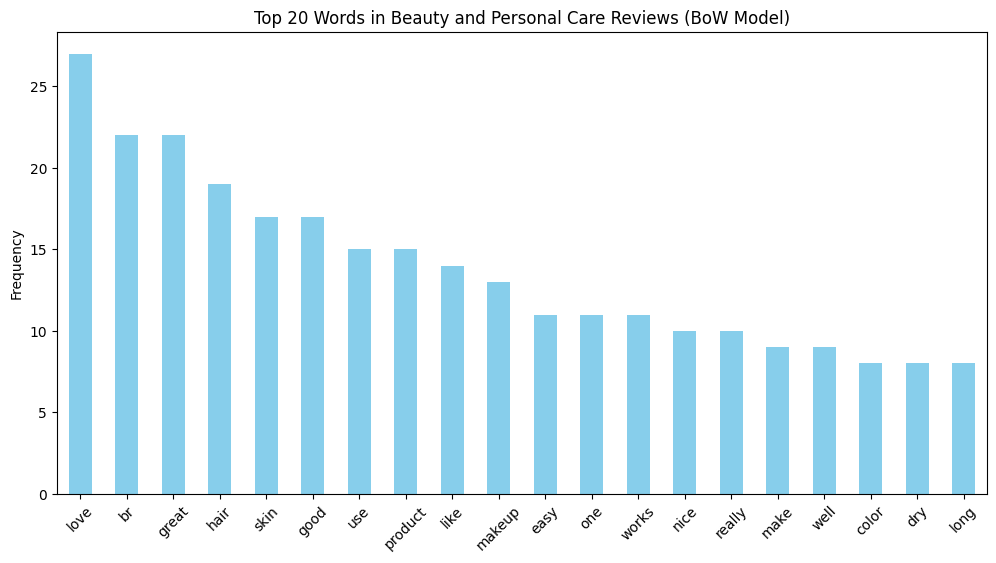

In [ ]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pandas as pd

# Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Extract a sample of 100 reviews for demonstration
reviews = [ds[i]['text'] for i in range(100)]

# Initialize CountVectorizer with stopword removal and fitting it on reviews
stop_words = stopwords.words('english')
vectorizer = CountVectorizer(stop_words=stop_words, max_features=20)  # Limit to top 20 words
bow_matrix = vectorizer.fit_transform(reviews)

# Convert BoW matrix to a DataFrame for easier visualization
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Display the first few rows of the BoW DataFrame
print("BoW Representation (First 5 Rows):")
print(bow_df.head())

# Sum the word counts for visualization
word_counts = bow_df.sum(axis=0).sort_values(ascending=False)

# Plot: Bar plot of the top 20 words in the BoW model
plt.figure(figsize=(12, 6))
word_counts.plot(kind='bar', color='skyblue')
plt.title('Top 20 Words in Beauty and Personal Care Reviews (BoW Model)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

BoW Representation (First 5 Rows):
   br  color  dry  easy  good  great  hair  like  long  love  make  makeup  \
0   0      0    0     0     0      0     1     1     0     0     0       0   
1   0      0    0     0     0      1     0     0     0     0     0       0   
2   0      0    0     0     0      1     0     2     0     0     0       0   
3   0      0    0     0     0      0     0     0     0     0     0       0   
4   0      0    1     0     0      0     0     0     1     3     1       0   

   nice  one  product  really  skin  use  well  works  
0     0    0        0       0     0    0     0      0  
1     0    0        1       0     0    0     0      0  
2     0    0        0       0     0    0     0      1  
3     1    0        0       0     0    0     0      0  
4     0    0        1       0     1    0     0      0  


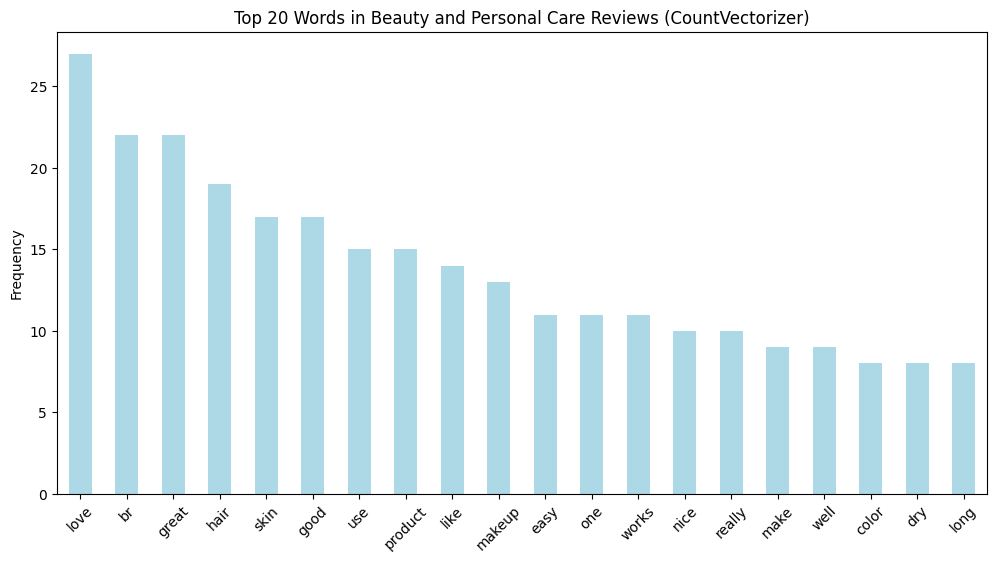

In [ ]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt

# Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Step 2: Extract the first 100 reviews for demonstration
reviews = [ds[i]['text'] for i in range(100)]

# Step 3: Initialize CountVectorizer
stop_words = stopwords.words('english')  # Remove common stopwords
vectorizer = CountVectorizer(stop_words=stop_words, max_features=20)  # Limit to top 20 words

# Step 4: Fit and transform the reviews to create a Bag-of-Words matrix
bow_matrix = vectorizer.fit_transform(reviews)

# Step 5: Convert the BoW matrix to a DataFrame for visualization
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Step 6: Display the DataFrame with word counts
print("BoW Representation (First 5 Rows):")
print(bow_df.head())

# Step 7: Plot the top 20 words by their frequency
word_counts = bow_df.sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
word_counts.plot(kind='bar', color='lightblue')
plt.title('Top 20 Words in Beauty and Personal Care Reviews (CountVectorizer)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

TF-IDF Representation (First 5 Rows):
    br  color       dry  easy  good     great      hair      like      long  \
0  0.0    0.0  0.000000   0.0   0.0  0.000000  0.707107  0.707107  0.000000   
1  0.0    0.0  0.000000   0.0   0.0  0.655615  0.000000  0.000000  0.000000   
2  0.0    0.0  0.000000   0.0   0.0  0.343688  0.000000  0.830646  0.000000   
3  0.0    0.0  0.000000   0.0   0.0  0.000000  0.000000  0.000000  0.000000   
4  0.0    0.0  0.338553   0.0   0.0  0.000000  0.000000  0.000000  0.338553   

       love      make  makeup  nice  one   product  really      skin  use  \
0  0.000000  0.000000     0.0   0.0  0.0  0.000000     0.0  0.000000  0.0   
1  0.000000  0.000000     0.0   0.0  0.0  0.755095     0.0  0.000000  0.0   
2  0.000000  0.000000     0.0   0.0  0.0  0.000000     0.0  0.000000  0.0   
3  0.000000  0.000000     0.0   1.0  0.0  0.000000     0.0  0.000000  0.0   
4  0.712298  0.317187     0.0   0.0  0.0  0.278362     0.0  0.292064  0.0   

   well    works  
0   0

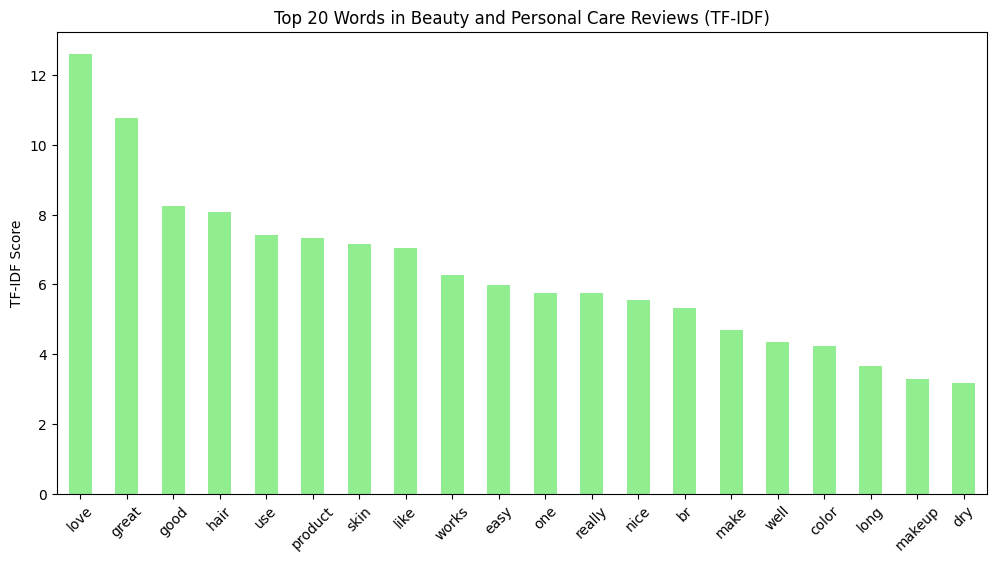

In [ ]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt

# Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Step 2: Extract the first 100 reviews for demonstration
reviews = [ds[i]['text'] for i in range(100)]

# Step 3: Initialize TfidfVectorizer
stop_words = stopwords.words('english')  # Remove common stopwords
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=20)  # Limit to top 20 words

# Step 4: Fit and transform the reviews to create a TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(reviews)

# Step 5: Convert the TF-IDF matrix to a DataFrame for visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Step 6: Display the DataFrame with TF-IDF scores
print("TF-IDF Representation (First 5 Rows):")
print(tfidf_df.head())

# Step 7: Sum the TF-IDF scores for each word
word_tfidf = tfidf_df.sum(axis=0).sort_values(ascending=False)

# Step 8: Plot the top 20 words by their TF-IDF scores
plt.figure(figsize=(12, 6))
word_tfidf.plot(kind='bar', color='lightgreen')
plt.title('Top 20 Words in Beauty and Personal Care Reviews (TF-IDF)')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45)
plt.show()

In [ ]:
!pip install datasets scikit-learn nltk

In [ ]:
# Step 1: Import necessary libraries
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
import nltk
import pandas as pd

# Step 2: Download necessary NLTK resources
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))  # Convert stop_words set to a list

# Step 3: Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Step 4: Filter and map ratings to binary labels
# Map ratings: 1-2 -> 0 (Negative), 4-5 -> 1 (Positive), exclude 3
df = pd.DataFrame(ds)  # Convert dataset to a pandas DataFrame for easier manipulation
df = df[df['rating'] != 3]  # Exclude neutral ratings
df['label'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)  # Map to binary labels

# Extract text and labels
texts = df['text'].tolist()
labels = df['label'].tolist()

# Step 5: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Step 6: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)  # Limiting to top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 7: Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

# Step 8: Make predictions on the test set
y_pred = rf_classifier.predict(X_test_tfidf)

# Step 9: Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 77.14%

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.06      0.11        17
    Positive       0.77      1.00      0.87        53

    accuracy                           0.77        70
   macro avg       0.88      0.53      0.49        70
weighted avg       0.82      0.77      0.68        70



In [ ]:
# Step 1: Import necessary libraries
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
import nltk

# Step 2: Download necessary NLTK resources
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))  # Convert stop_words set to list

# Step 3: Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Step 4: Prepare the data (train-test split)
# Extract text and labels from the dataset
texts = ds['text']  # Adjust the field name if necessary
labels = ds['rating']  # Use 'rating' as the target column

# Step 5: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)  # Limiting to top 5000 words
X = vectorizer.fit_transform(texts)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Step 6: Train a Logistic Regression Model
lr_classifier = LogisticRegression(max_iter=100)  # Setting max_iter to 100 for convergence
lr_classifier.fit(X_train, y_train)

# Step 7: Make predictions on the test set
y_pred = lr_classifier.predict(X_test)

# Step 8: Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 61.04%

Classification Report:
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         8
         2.0       0.00      0.00      0.00         7
         3.0       0.00      0.00      0.00         5
         4.0       0.00      0.00      0.00        10
         5.0       0.61      1.00      0.76        47

    accuracy                           0.61        77
   macro avg       0.12      0.20      0.15        77
weighted avg       0.37      0.61      0.46        77



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Step 1: Import necessary libraries
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
import nltk
import xgboost as xgb

# Step 2: Download necessary NLTK resources
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))  # Convert stop_words set to list

# Step 3: Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Step 4: Prepare the data (train-test split)
# Extract text and labels from the dataset
texts = ds['text']  # Ensure this field exists in your dataset
labels = ds['rating']  # Use 'rating' as the target column

# Optional: Convert ratings into binary classes (e.g., Positive: >=4, Negative: <4)
labels = [1 if rating >= 4 else 0 for rating in labels]  # 1 = Positive, 0 = Negative

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Step 5: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)  # Limiting to top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 6: Train an XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')  # Setting evaluation metric
xgb_classifier.fit(X_train_tfidf, y_train)

# Step 7: Make predictions on the test set
y_pred = xgb_classifier.predict(X_test_tfidf)

# Step 8: Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 72.73%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.46      0.30      0.36        20
    Positive       0.78      0.88      0.83        57

    accuracy                           0.73        77
   macro avg       0.62      0.59      0.60        77
weighted avg       0.70      0.73      0.71        77



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:23:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Step 1: Import necessary libraries
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from nltk.corpus import stopwords
import nltk

# Step 2: Download necessary NLTK resources
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))  # Convert stop_words set to list

# Step 3: Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Step 4: Prepare the data (train-test split)
# Extract text and labels from the dataset
texts = ds['text']  # Ensure 'text' exists in your dataset
ratings = ds['rating']  # Ensure 'rating' exists in your dataset

# Optional: Convert ratings into binary classes (e.g., Positive: >=4, Negative: <4)
labels = [1 if rating >= 4 else 0 for rating in ratings]  # 1 = Positive, 0 = Negative

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Step 5: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)  # Limiting to top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Function to train and evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
    print("=" * 50)

# Step 6: Logistic Regression Model
print("Logistic Regression Model Performance:")
lr_classifier = LogisticRegression(max_iter=100)
evaluate_model(lr_classifier, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Step 7: Random Forest Classifier
print("Random Forest Classifier Performance:")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_classifier, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Step 8: XGBoost Classifier
print("XGBoost Classifier Performance:")
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb_classifier, X_train_tfidf, X_test_tfidf, y_train, y_test)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Logistic Regression Model Performance:
Accuracy: 74.03%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        20
    Positive       0.74      1.00      0.85        57

    accuracy                           0.74        77
   macro avg       0.37      0.50      0.43        77
weighted avg       0.55      0.74      0.63        77

Random Forest Classifier Performance:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 74.03%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.05      0.09        20
    Positive       0.75      0.98      0.85        57

    accuracy                           0.74        77
   macro avg       0.62      0.52      0.47        77
weighted avg       0.68      0.74      0.65        77

XGBoost Classifier Performance:
Accuracy: 72.73%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.46      0.30      0.36        20
    Positive       0.78      0.88      0.83        57

    accuracy                           0.73        77
   macro avg       0.62      0.59      0.60        77
weighted avg       0.70      0.73      0.71        77



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:26:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


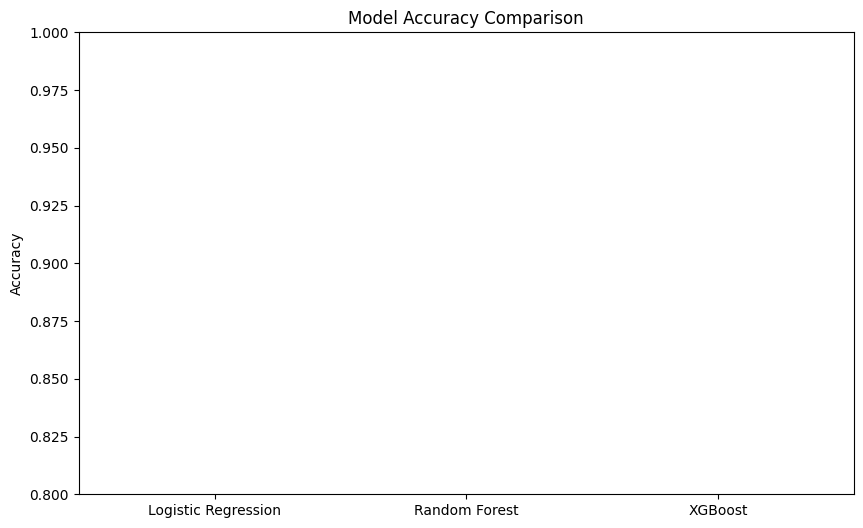

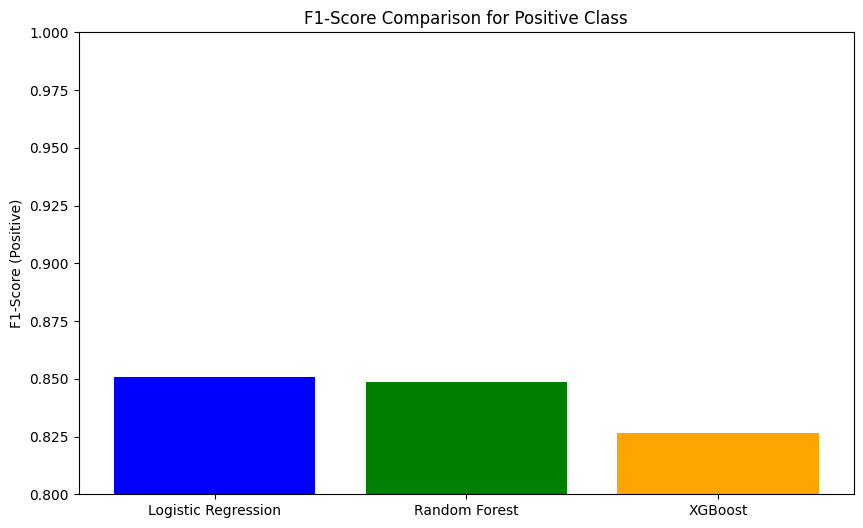

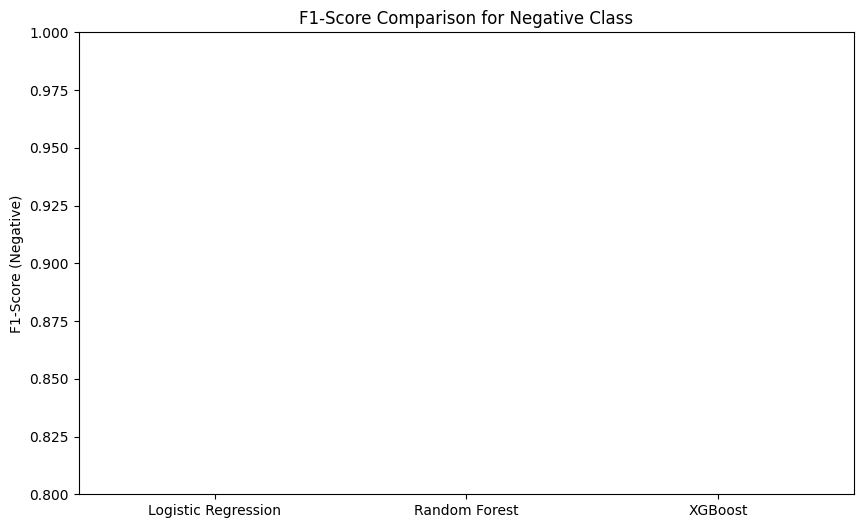

In [ ]:
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

# Step 1: Download necessary NLTK resources
nltk.download('stopwords')
stop_words = list(stopwords.words('english'))

# Step 2: Load the sampled dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Step 3: Prepare the data (train-test split)
texts = ds['text']
ratings = ds['rating']
labels = [1 if rating >= 4 else 0 for rating in ratings]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Step 4: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 5: Define and train models
lr_classifier = LogisticRegression(max_iter=100)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_classifier = xgb.XGBClassifier(eval_metric='logloss')

def evaluate_model_graph(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, target_names=['Negative', 'Positive'], zero_division=0)
    f1_positive = report['Positive']['f1-score']
    f1_negative = report['Negative']['f1-score']
    return accuracy, f1_positive, f1_negative

# Evaluate each model
lr_accuracy, lr_f1_pos, lr_f1_neg = evaluate_model_graph(lr_classifier, X_train_tfidf, X_test_tfidf, y_train, y_test)
rf_accuracy, rf_f1_pos, rf_f1_neg = evaluate_model_graph(rf_classifier, X_train_tfidf, X_test_tfidf, y_train, y_test)
xgb_accuracy, xgb_f1_pos, xgb_f1_neg = evaluate_model_graph(xgb_classifier, X_train_tfidf, X_test_tfidf, y_train, y_test)

# Plot results
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = [lr_accuracy, rf_accuracy, xgb_accuracy]
f1_pos_scores = [lr_f1_pos, rf_f1_pos, xgb_f1_pos]
f1_neg_scores = [lr_f1_neg, rf_f1_neg, xgb_f1_neg]

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

# Plot F1-Score (Positive)
plt.figure(figsize=(10, 6))
plt.bar(models, f1_pos_scores, color=['blue', 'green', 'orange'])
plt.title('F1-Score Comparison for Positive Class')
plt.ylabel('F1-Score (Positive)')
plt.ylim([0.8, 1.0])
plt.show()

# Plot F1-Score (Negative)
plt.figure(figsize=(10, 6))
plt.bar(models, f1_neg_scores, color=['blue', 'green', 'orange'])
plt.title('F1-Score Comparison for Negative Class')
plt.ylabel('F1-Score (Negative)')
plt.ylim([0.8, 1.0])
plt.show()



# Pre training model

In [ ]:
# Step 1: Import necessary libraries
from transformers import pipeline

# Step 2: Load the pre-trained DistilBERT model fine-tuned on SST-2
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

# Step 3: Define some example text to classify
texts = [
    "I love this! It's absolutely amazing.",
    "This was the worst experience of my life. I hated it.",
    "The product was a bit dull, but the price was great.",
    "I enjoyed personal care, but the quality was lacking.",

]

# Step 4: Classify the text
results = classifier(texts)

# Step 5: Display the results
for text, result in zip(texts, results):
    print(f"Text: {text}\nSentiment: {result['label']}, Confidence: {result['score']:.2f}\n")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Text: I love this! It's absolutely amazing.
Sentiment: POSITIVE, Confidence: 1.00

Text: This was the worst experience of my life. I hated it.
Sentiment: NEGATIVE, Confidence: 1.00

Text: The product was a bit dull, but the price was great.
Sentiment: POSITIVE, Confidence: 1.00

Text: I enjoyed personal care, but the quality was lacking.
Sentiment: NEGATIVE, Confidence: 1.00



In [ ]:
# Step 1: Import necessary libraries
from transformers import pipeline
from datasets import load_dataset

# Step 2: Load dataset from Hugging Face
ds = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Beauty_and_Personal_Care", split="full")

# Step 3: Load the pre-trained DistilBERT model fine-tuned on SST-2
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

# Step 4: Extract a sample of reviews to classify (for demo purposes, let's take 5 reviews)
reviews = ds['text'][:5]  # Take the first 5 reviews from the dataset

# Step 5: Use the DistilBERT model to classify the sentiment of the reviews
results = classifier(reviews)

# Step 6: Display the results
for review, result in zip(reviews, results):
    print(f"Review: {review}\nSentiment: {result['label']}, Confidence: {result['score']:.2f}\n")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Review: Opened the package & instant migraine. I cannot believe the stench.  I have purchased other packages that did not smell at all so I do not know if these were a damaged shipment or damaged during packaging or what, but the minute I opened the Amazon package I smelled it before I even opened the Terra Tattoos package. I couldn’t believe it. Then I find that the pink inks from the back have smeared all over the fronts of the tattoos. Yes, you eventually take the clear part off to apply the tattoo, but I always lay it down with the clear covering first to line it up & I didn’t want to risk the pink ink transferring to my art projects so it’s going back. I’ll update the review when Amazon sends my replacement. I’m upset because now my resin is here & I don’t have the tattoos to do my project, but I’m more mad about the fact that I have a massive migraine because of the gasoline fumes that lingered.  I believe they arrived a week ago, but I didn’t check the tattoos then as I didn’t h

In [ ]:
!pip install transformers datasets torch accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00


In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
import evaluate
from datasets import load_dataset


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
import torch
import evaluate

# Step 1: Load the dataset
ds = load_dataset("json", data_files="sampled_data.jsonl", split="train")

# Step 2: Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    tokens = tokenizer(examples['text'], padding="max_length", truncation=True)
    tokens['labels'] = [int(rating >= 4) for rating in examples['rating']]  # Binary labels
    return tokens

# Step 3: Split the dataset into train and test sets
split_ds = ds.train_test_split(test_size=0.2, seed=42)
train_ds = split_ds['train']
eval_ds = split_ds['test']

# Tokenize the train and test datasets
train_ds = train_ds.map(tokenize_function, batched=True)
eval_ds = eval_ds.map(tokenize_function, batched=True)

# Remove unnecessary columns
train_ds = train_ds.remove_columns(["text", "rating"])
eval_ds = eval_ds.remove_columns(["text", "rating"])

# Set the format for PyTorch
train_ds.set_format("torch")
eval_ds.set_format("torch")

# Step 4: Load the model
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2  # Binary classification
)

# Step 5: Load the accuracy metric
accuracy = evaluate.load("accuracy")

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return accuracy.compute(predictions=predictions, references=labels)

# Step 6: Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Updated key
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    push_to_hub=False,
    report_to='none'
)

# Step 7: Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics
)

# Step 8: Train the model
trainer.train()




Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.501252,0.792208


TrainOutput(global_step=20, training_loss=0.5945292472839355, metrics={'train_runtime': 4.9342, 'train_samples_per_second': 62.421, 'train_steps_per_second': 4.053, 'total_flos': 40799958786048.0, 'train_loss': 0.5945292472839355, 'epoch': 1.0})

In [ ]:
# Save the model
trainer.save_model('./my_finetuned_model')
tokenizer.save_pretrained('./my_finetuned_model')

('./my_finetuned_model/tokenizer_config.json',
 './my_finetuned_model/special_tokens_map.json',
 './my_finetuned_model/vocab.txt',
 './my_finetuned_model/added_tokens.json',
 './my_finetuned_model/tokenizer.json')

In [ ]:
from transformers import pipeline

# Load the trained model
classifier = pipeline("sentiment-analysis", model='./my_finetuned_model', tokenizer=tokenizer)

# Test with some new text
test_texts = ["This product was great!", "The worse experience in my life"]
predictions = classifier(test_texts)

# Print predictions
for text, prediction in zip(test_texts, predictions):
    print(f"Text: {text}\nPrediction: {prediction['label']} with confidence {prediction['score']:.2f}\n")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Text: This product was great!
Prediction: LABEL_1 with confidence 0.75

Text: The worse experience in my life
Prediction: LABEL_1 with confidence 0.69

